# Setup

In [1]:

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig


# idea:
# do in higher precision because things are so smol


In [2]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"

# NOTE! We need to monkeypatch transformer lens to use register_full_backward_hook
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


## Load SAEs

In [3]:

from safetensors.torch import load_file
from collections import defaultdict


import sys
if not "/home/dev/sae-k-sparse-mamba/sae" in sys.path:
    sys.path.append("/home/dev/sae-k-sparse-mamba")
import os
os.chdir('/home/dev/sae-k-sparse-mamba')
saes = []
from importlib import reload
import sae
reload(sae.sae)
from sae.sae import Sae

try_lrs = ['7e-05', '8e-05', '9e-05', '0.0001', '0.00011', '0.000115', '0.00012', '0.000125', '0.00013', '0.0001414213562373095',
          '0.00015', '0.00016', '0.00017', '0.00018']

#/home/dev/sae-k-sparse-mamba/7e-05 initialTry130.txthook_embed/hook_hook_embed.pt/cfg.json
#/home/dev/sae-k-sparse-mamba/7e-05 initialTry130.txthook_embed

paths = [' initialTry106.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/ initialTry105.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/ initialTry104.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/ initialTry103.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/ initialTry102.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/0.00017 initialTry101.txthook_embed/hook_hook_embed.pt',
         '/home/dev/sae-k-sparse-mamba/0.00018 initialTry100.txthook_embed/hook_hook_embed.pt']
for i in range(40):
    print(i)
    #lr = try_lrs[i]
    #print(lr)
    ckpt_dir = "/home/dev/sae-k-sparse-mamba/"
    #path = ["/home/dev/sae-k-sparse-mamba/" + f for f in os.listdir(ckpt_dir) if str(lr) in f][0] + '/hook_hook_embed.pt'
    path = f'/home/dev/sae-k-sparse-mamba/blocks.{i}.hook_resid_pre/hook_blocks.{i}.hook_resid_pre.pt'
    #path = paths[i]
    saes.append(Sae.load_from_disk(path, hook=f'blocks.{i}.hook_resid_pre', device=model.cfg.device))
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [4]:

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 200
seed = 27
valid_seed = 28
constrain_to_answers = True
# this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
has_symmetric_patching = True

n1_patchings = ["""
ABC BC A
DBC BC D""",
    """
ABC CB A
DBC CB D"""]

n2_patchings = ["""
ABC AC B
ADC AC D""",
    """
ABC CA B
ADC CA D"""]

n3_patchings = ["""
ABC AB C
ABD AB D""",
    """
ABC BA C
ABD BA D"""]

n4_patchings = ["""
ABC AC B
ABC BC A""",
    """
ABC AB C
ABC CB A""",
    """
ABC BA C
ABC CA B"""]

n5_patchings = ["""
ABC CA B
ABC CB A
""",
    """
ABC BA C
ABC BC A""",
    """
ABC AB C
ABC AC B"""]

patchings = {
    'n1': n1_patchings,
    'n2': n2_patchings,
    'n3': n3_patchings,
    'n4': n4_patchings,
    'n5': n5_patchings
}

all_patchings = []
for patching in patchings.values():
    all_patchings += patching
all_patchings = sorted(all_patchings) # make deterministic 

patch_all_names = ["""
ABC AB C
DEF DE F""",
    """
ABC AC B
DEF DF E""",     
    """
ABC BA C
DEF ED F""",
    """
ABC BC A
DEF EF D""",
    """
ABC CA B
DEF FD E""",
    """
ABC CB A
DEF FE D"""]


patchings['all'] = all_patchings
patchings['allatonce'] = patch_all_names
from acdc.data.ioi import BABA_TEMPLATES
templates = ABC_TEMPLATES
#patching_formats = list(get_all_single_name_abc_patching_formats())
PATCHING_FORMAT_I = 'all'
patching_formats = [x.strip() for x in patchings[PATCHING_FORMAT_I]]

print("using patching format")
for patch in patching_formats:
    print(patch)
    print("")
#print(patching_formats)

data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)


import acdc.data.ioi
from collections import defaultdict
name_positions_map = defaultdict(lambda: [])
for template in templates:
    name = acdc.data.ioi.good_names[0]
    template_filled_in = template.replace("[NAME]", name)
    template_filled_in = template_filled_in.replace("[PLACE]", acdc.data.ioi.good_nouns['[PLACE]'][0])
    template_filled_in = template_filled_in.replace("[OBJECT]", acdc.data.ioi.good_nouns['[OBJECT]'][0])
    # get the token positions of the [NAME] in the prompt
    name_positions = tuple([(i) for (i,s) in enumerate(model.to_str_tokens(torch.tensor(model.tokenizer.encode(template_filled_in)))) if s == f' {name}'])
    name_positions_map[name_positions].append(template)
sorted_by_frequency = sorted(list(name_positions_map.items()), key=lambda x: -len(x[1]))
most_frequent_name_positions, templates = sorted_by_frequency[0]
print("using templates")
for template in templates:
    print(template)
print(f"with name positions {most_frequent_name_positions}")

data = generate_dataset(model=model,
              data_generator=ioi_data_generator,
              num_patching_pairs=num_patching_pairs,
              seed=seed,
              valid_seed=valid_seed,
              constrain_to_answers=constrain_to_answers,
              has_symmetric_patching=has_symmetric_patching, 
              varying_data_lengths=True,
              templates=templates,
              patching_formats=patching_formats)



using patching format
ABC AB C
ABC AC B

ABC AB C
ABC CB A

ABC AB C
ABD AB D

ABC AC B
ABC BC A

ABC AC B
ADC AC D

ABC BA C
ABC BC A

ABC BA C
ABC CA B

ABC BA C
ABD BA D

ABC BC A
DBC BC D

ABC CA B
ABC CB A

ABC CA B
ADC CA D

ABC CB A
DBC CB D

using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Afterwards [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Friends [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)


# Eval with SAEs

In [87]:
from functools import partial


from mamba_lens.input_dependent_hooks import clean_hooks
clean_hooks(model)
for i in range(23):
    sae_hooks = [(f'blocks.{layer}.hook_layer_input', partial(sae_hook, layer=layer)) for layer in range(0,22)]
    #sae_hooks = [(f'hook_embed', partial(sae_hook, layer=layer)) for layer in range(i,i+1)]
    
    model_kwargs = {
        "fast_ssm": True,
        "fast_conv": True
    }
    from acdc import ACDCEvalData, get_pad_token
    def logging_incorrect_metric(data: ACDCEvalData):
        pad_token = get_pad_token(model.tokenizer)
        for data_subset in [data.patched, data.corrupted]:
            batch, _ = data_subset.data.size()
            for b in range(batch):
                if not data_subset.top_is_correct[b].item():
                    toks = data_subset.data[b][:data_subset.last_token_position[b]+1]
                    print("failed on this data point:")
                    print(model.tokenizer.decode(toks))
                    print("correct prs:")
                    for i, tok in enumerate(data_subset.correct[b]):
                        if tok.item() != pad_token:
                            print(data_subset.correct_prs[b,i].item(), model.tokenizer.decode([tok.item()]))
                    print("incorrect prs:")
                    for i, tok in enumerate(data_subset.incorrect[b]):
                        if tok.item() != pad_token:
                            print(data_subset.incorrect_prs[b,i].item(), model.tokenizer.decode([tok.item()]))
        return data.patched.correct_prs[:,0]
    
    from acdc import accuracy_metric, wrap_run_with_hooks
    acc = data.eval(model=wrap_run_with_hooks(model=model, fwd_hooks=sae_hooks, **model_kwargs),
                    batch_size=10,
                    metric=accuracy_metric).mean()
    #acc_no_sae = data.eval(model=wrap_run_with_hooks(model=model, fwd_hooks=[], **model_kwargs),
    #                batch_size=10,
    #                metric=accuracy_metric).mean()
    print(22)
    print(f"patching with SAEs, got accuracy {acc}")
    break



torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
t

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcb66657130>>
Traceback (most recent call last):
  File "/opt/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
torch.Size([10, 1024])
torch.Size([10, 20, 32]) torch.Size([10, 20, 32])
t

In [ ]:

'''
hook_embed
7e-05
patching with SAEs, got accuracy 0.8374999761581421
8e-05
patching with SAEs, got accuracy 0.824999988079071
9e-05
patching with SAEs, got accuracy 0.8349999785423279
0.0001
patching with SAEs, got accuracy 0.8100000023841858
0.00011
patching with SAEs, got accuracy 0.8100000023841858
0.000115
patching with SAEs, got accuracy 0.7599999904632568
0.00012
patching with SAEs, got accuracy 0.8449999690055847
0.000125
patching with SAEs, got accuracy 0.8174999952316284
0.00013
patching with SAEs, got accuracy 0.7749999761581421
0.0001414213562373095
patching with SAEs, got accuracy 0.8174999952316284
0.00015
patching with SAEs, got accuracy 0.8324999809265137
0.00016
patching with SAEs, got accuracy 0.79749995470047
0.00017
patching with SAEs, got accuracy 0.8100000023841858
0.00018
patching with SAEs, got accuracy 0.8199999928474426
'''

'''
24
patching with SAEs, got accuracy 0.8025000095367432
/home/dev/sae-k-sparse-mamba/0.00013 initialTry105.txthook_embed/hook_hook_embed.pt
23
patching with SAEs, got accuracy 0.8399999737739563
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry104.txthook_embed/hook_hook_embed.pt
22
patching with SAEs, got accuracy 0.887499988079071
/home/dev/sae-k-sparse-mamba/0.00015 initialTry103.txthook_embed/hook_hook_embed.pt
21
patching with SAEs, got accuracy 0.8824999928474426
/home/dev/sae-k-sparse-mamba/0.00016 initialTry102.txthook_embed/hook_hook_embed.pt
20
patching with SAEs, got accuracy 0.8824999928474426
/home/dev/sae-k-sparse-mamba/0.00017 initialTry101.txthook_embed/hook_hook_embed.pt
19
patching with SAEs, got accuracy 0.9024999737739563
/home/dev/sae-k-sparse-mamba/0.00018 initialTry100.txthook_embed/hook_hook_embed.pt
18
patching with SAEs, got accuracy 0.8999999761581421
/home/dev/sae-k-sparse-mamba/0.00012 initialTry106.txthook_embed/hook_hook_embed.pt
18
patching with SAEs, got accuracy 0.8999999761581421
/home/dev/sae-k-sparse-mamba/0.00013 initialTry105.txthook_embed/hook_hook_embed.pt
17
patching with SAEs, got accuracy 0.9049999713897705
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry104.txthook_embed/hook_hook_embed.pt
16
patching with SAEs, got accuracy 0.9149999618530273
/home/dev/sae-k-sparse-mamba/0.00015 initialTry103.txthook_embed/hook_hook_embed.pt
15
patching with SAEs, got accuracy 0.9199999570846558
/home/dev/sae-k-sparse-mamba/0.00016 initialTry102.txthook_embed/hook_hook_embed.pt
14
patching with SAEs, got accuracy 0.9199999570846558
/home/dev/sae-k-sparse-mamba/0.00017 initialTry101.txthook_embed/hook_hook_embed.pt
13
patching with SAEs, got accuracy 0.9124999642372131
/home/dev/sae-k-sparse-mamba/0.00018 initialTry100.txthook_embed/hook_hook_embed.pt
12
patching with SAEs, got accuracy 0.92249995470047
11
patching with SAEs, got accuracy 0.9174999594688416
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry104.txthook_embed/hook_hook_embed.pt
10
patching with SAEs, got accuracy 0.9149999618530273
/home/dev/sae-k-sparse-mamba/0.00015 initialTry103.txthook_embed/hook_hook_embed.pt
9
patching with SAEs, got accuracy 0.9174999594688416
/home/dev/sae-k-sparse-mamba/0.00016 initialTry102.txthook_embed/hook_hook_embed.pt
8
patching with SAEs, got accuracy 0.9199999570846558
/home/dev/sae-k-sparse-mamba/0.00017 initialTry101.txthook_embed/hook_hook_embed.pt
7
patching with SAEs, got accuracy 0.9149999618530273
/home/dev/sae-k-sparse-mamba/0.00018 initialTry100.txthook_embed/hook_hook_embed.pt
6
patching with SAEs, got accuracy 0.9099999666213989
5
patching with SAEs, got accuracy 0.92249995470047
/home/dev/sae-k-sparse-mamba/0.00013 initialTry105.txthook_embed/hook_hook_embed.pt
4
patching with SAEs, got accuracy 0.9274999499320984
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry104.txthook_embed/hook_hook_embed.pt
3
patching with SAEs, got accuracy 0.9199999570846558
/home/dev/sae-k-sparse-mamba/0.00015 initialTry103.txthook_embed/hook_hook_embed.pt
2
patching with SAEs, got accuracy 0.9249999523162842
/home/dev/sae-k-sparse-mamba/0.00016 initialTry102.txthook_embed/hook_hook_embed.pt
1
patching with SAEs, got accuracy 0.9249999523162842
/home/dev/sae-k-sparse-mamba/0.00017 initialTry101.txthook_embed/hook_hook_embed.pt
0
patching with SAEs, got accuracy 0.9624999761581421
'''

# Run Edge Attribution Patching with Integrated Gradients

In [10]:
# from tqdm import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from mamba_lens.input_dependent_hooks import clean_hooks
from tqdm import tqdm
from einops import rearrange

model_kwargs = {
    'fast_ssm': False,
    'fast_conv': False
}
BATCH_SIZE = 4

# removes all hooks including "leftover" ones that might stick around due to interrupting the model at certain times
clean_hooks(model)

def normalized_logit_diff_metric(patched_logits, unpatched_logits, corrupted_logits, patched_correct, corrupted_correct, also_return_acc=False):
    B,V = patched_logits.size()

    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = unpatched_logits[torch.arange(B), patched_correct]
    A_logits_patched = patched_logits[torch.arange(B), patched_correct]
    A_logits_corrupted = corrupted_logits[torch.arange(B), patched_correct]

    B_logits_unpatched = unpatched_logits[torch.arange(B), corrupted_correct]
    B_logits_patched = patched_logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = corrupted_logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    # the abs ensures that if it's wrong we don't try and make it more wrong
    possible_range = torch.abs(max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    
    normalized_diff = (diff-min_diff)/possible_range

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted
    res = torch.mean(normalized_diff)
    
    if also_return_acc:
        num_correct = A_logits_patched > B_logits_patched
        acc = torch.sum(num_correct)/B
        return res, acc
    else:
        return res


# there's a subtle bug if you aren't careful:
# consider what happens when we do edge attribution patching and patch every edge
# what we want to happen is that it's identical to corrupted
# however this is not what happens!
# Start with layer 0:
# layer 0 will be patched
#    we subtract uncorrupted embed and add corrupted embed
#    in other words, the embed input to layer 0 will be from the corrupted run
# this results in layer 0 having an output of corrupted, as desired
# now consider layer 1
#    subtract uncorrupted embed and add corrupted embed
#      this is fine and results in embed input to layer 1 of corrupted
#    subtract uncorrupted layer 0 and add corrupted layer 0
#      layer 0 is already corrupted, so this has the effect of the output of layer 0 being
#          2*corrupted layer 0 - uncorrupted layer 0
#          this is not the same as corrupted!

# two ways to fix this:
# 1. fetch stored layer_input from uncorrupted run, and use that instead of the layer_input given in fwd_diff
#   this works, but then the gradients won't propogate properly (maybe? todo: test)
# 2. mark which edges are patched and don't "double patch" them
#   if we are patching all edges, this means that we simply apply only the embed diff to all layers,
#   as that'll result in all layers being patched
# 3. just subtract the outputs in the same forward pass, instead of a cached "unpatched" run
#  we do 3

global alpha
alpha = 1

global cached_outputs
global corrupted_outputs

############### INPUTS TO LAYERS ###################

def cache_output_hook( # hook_layer_output
    layer_output : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int):
    global cached_outputs
    cached_outputs[layer+1] = layer_output
    return layer_output

def fwd_diff_hook( # hook_layer_input
    layer_input : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int):
    global alpha
    global cached_outputs
    global corrupted_outputs
    return layer_input + (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1]).sum(dim=0)*alpha

global attributions
def bwd_diff_hook( # hook_layer_input
    grad : Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer : int,
    batch_start: int,
    batch_end: int):
    #print(f"running bwd with alpha {alpha} and layer {layer}") 
    global cached_outputs
    global corrupted_outputs
    global attributions
    # [N_upstream, B, L, D]
    upstream_diffs = (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1])
    # grad is [B,L,D]

    # to do a taylor approximation of metric with respect to diff_0, we
    # multiply diffs and grad, then
    # sum over the L and D dimensions (this is doing a dot product of vectors of size L*D)
    # now we have attr of size [N_upstream, B, L]
    attr = (grad*upstream_diffs).sum(dim=-1)
    # [B, N_upstream, L]           [N_upstream, B, L]
    attr         =   torch.transpose(attr, 0, 1)
    # [B, N_upstream, L]
    attr = attr.clone().detach()
    if POSITIONS:
        attributions[batch_start:batch_end,:layer+1,layer+1] += attr
    else:
        #[B, N_upstream]
        attr = attr.sum(dim=-1)
        attributions[batch_start:batch_end,:layer+1,layer+1] += attr


#################### CONV HOOKS ######################
def cache_conv_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int):
    global cached_conv_inputs
    cached_conv_inputs.append(conv_input)
    return conv_input

# for each conv slice,
# we have 
global slice_terms
global cached_conv_inputs
global corrupted_conv_inputs
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual slices
    global alpha
    global slice_terms
    global cached_conv_inputs
    global corrupted_conv_inputs

    # we have two input hooks, the second one is the one we want
    D_CONV = model.cfg.d_conv

    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    uncorrupted_input = rearrange(cached_conv_inputs[layer], 'B L E -> B E L')
    corrupted_input = rearrange(corrupted_conv_inputs[layer], 'B L E -> B E L')
    B,E,L = uncorrupted_input.size()
    uncorrupted_input = torch.nn.functional.pad(uncorrupted_input, (D_CONV-1,0), mode='constant', value=0)
    corrupted_input = torch.nn.functional.pad(corrupted_input, (D_CONV-1,0), mode='constant', value=0)
    #print(uncorrupted_input.size(), corrupted_input.size())
    # we want some "patch hook" thing that uses autodiff or somethin
    output = torch.zeros([B,E,L], device=model.cfg.device)
    layer_slices = []
    for i in range(D_CONV):
        # [B,E,L]                      [E,1]                      [B,E,L]
        uncorrupted_contribution = conv_weight[:,0,i].view(E,1)*uncorrupted_input[:,:,i:i+L]
        corrupted_contribution = conv_weight[:,0,i].view(E,1)*corrupted_input[:,:,i:i+L]
        slice_term = uncorrupted_contribution*(1-alpha)+corrupted_contribution*(alpha)
        diff = -uncorrupted_contribution+corrupted_contribution
        slice_term.retain_grad()
        #slice_term.requires_grad = True
        layer_slices.append((diff, slice_term))
        output += slice_term
    output = rearrange(output, 'B E L -> B L E')
    output += conv_bias
    slice_terms.append(layer_slices)
    return output

def bwd_conv_hook(
    grad : Float[torch.Tensor, "B L E"], # we don't use this, hook is just so we are present in backward pass
    hook: HookPoint,
    layer : int,
    batch_start: int,
    batch_end: int,
):
    global slice_terms
    # [B, L, E]
    #diffs = (-cached_conv_inputs[layer]+corrupted_conv_inputs[layer])
    layer_slice_terms = slice_terms[layer]
    for slice_i, (diff, slice_term) in enumerate(layer_slice_terms):
        # [B,E,L]
        slice_grad = slice_term.grad
        # dot product over the E dimension
        # [B,L]         [B,E,L]   [B,E,L]
        slice_attr = (slice_grad * diff).sum(dim=-2) # sum over E dimension
        if POSITIONS:
            # [B,L]
            conv_attributions[batch_start:batch_end,layer,slice_i] += slice_attr 
        else:
            #[B]
            slice_attr = slice_attr.sum(dim=-1)
            conv_attributions[batch_start:batch_end,layer,slice_i] += slice_attr

####################### SAE HOOKS ##################

global sae_terms
global corrupted_sae_inputs


def get_index_into(indices):
    '''
    given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
    this gives you indexes you can use to access your values
    '''
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()
    second_axis_index = indices.flatten()
    return first_axis_index, second_axis_index


# TODO: maybe try flowing gradient to all values instead of just topK? idk
def sae_hook(
    x,
    hook,
    layer
):
    global sae_terms
    global corrupted_sae_inputs
    # s is [B,L,E]
    K = saes[layer].cfg.k
    sae = saes[layer]
    token_outs = []
    layer_sae_terms = []
    for l in range(x.size()[1]): # kernel can't handle doing all token positions at the same time
        # [B, NFeatures]                   [B,E]
        uncorrupted_features = sae.encode(x[:,l])
        # we cached the values before going into the sae, to save space
        # [B, NFeatures]                             [B,E]
        corrupted_features = sae.encode(corrupted_sae_inputs[layer][:,l])
        # [B, NFeatures]           [B,NFeatures]                  [B,NFeatures]
        weighted_features = uncorrupted_features*(1-alpha) + corrupted_features * alpha
        # [B,K]     [B,K]
        top_acts, top_indices = weighted_features.topk(K, sorted=False)
        # todo: recompute top_acts now we have top indices, using only the top sae values? idk if that loses info tho
        # we need the grad for attribution
        top_acts.retain_grad()
        # hacky thing to make 2D indexing work nicely
        index_B, index_Feat = get_index_into(top_indices)
        # get the diff (without alpha), needed for computing attribution
        #                                                                            view is needed because our indexing hack flattens it
        diff = (uncorrupted_features[index_B, index_Feat] + corrupted_features[index_B, index_Feat]).view(*top_acts.size())
        # store the two things needed for computing attributions
        layer_sae_terms.append((diff, top_acts, top_indices))
        
        sae_out = sae.decode(top_acts, top_indices)
        token_outs.append(sae_out)

    sae_terms.append(layer_sae_terms)
    token_outs = rearrange(token_outs, 'L B E -> B L E')    
    # [B,L,E]
    return token_outs

def bwd_sae_hook(
    grad,
    hook,
    layer,
    batch_start,
    batch_end):
    
    global sae_terms
    # [B, L, E]
    #diffs = (-cached_conv_inputs[layer]+corrupted_conv_inputs[layer])
    layer_slice_terms = sae_terms[layer]
    for token_pos, (diff, top_acts, top_indices) in enumerate(layer_slice_terms):
        # [B,K]
        top_acts_grad = top_acts.grad
        #print(f"got grad of {top_acts_grad}")
        # dot product over the E dimension
        # [B,K]           [B,K]          [B,K]
        top_acts_attr = (top_acts_grad * diff)
        B,K = top_acts_attr.size()
        for b in range(B):
            for i, index in enumerate(top_indices[b]):
                attr = top_acts_attr[b,i].item()
                if POSITIONS:
                    sae_attributions[layer][b+batch_start][token_pos][index] += attr
                    sae_counts[layer][b+batch_start][token_pos][index] += 1
                else:
                    sae_attributions[layer][b+batch_start][index] += attr
                    sae_counts[layer][b+batch_start][index] += 1



########## Compute Attributions ###############
B,L = data.data.size()
# our data is pairs of unpatched, corrupted
n_patching_pairs = B//2
D_CONV = model.cfg.d_conv

# attributions[b,i+1,j+1] is the (i->j) edge attribution for patching pair b
# attributions[b,0,j] is the (embed->j) edge attribution for patching pair b
# attributions[b,i,-1] is the (i->output) edge attribution for patching pair b
POSITIONS = True
if POSITIONS:
    attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2, L], device=model.cfg.device)
    conv_attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers, D_CONV, L], device=model.cfg.device)
    # just a few defaultdicts
    sae_attributions = defaultdict(lambda: # layer 
                                   defaultdict(lambda: # batch
                                                       defaultdict(lambda: # token pos
                                                                   defaultdict(lambda: # feature index
                                                                               0)))) # attr
    sae_counts = defaultdict(lambda: # layer 
                                   defaultdict(lambda: # batch
                                                       defaultdict(lambda: # token pos
                                                                   defaultdict(lambda: # feature index
                                                                               0)))) # count
else:
    attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2], device=model.cfg.device)
    conv_attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers, D_CONV], device=model.cfg.device)
    sae_attributions = defaultdict(lambda: # layer 
                                   defaultdict(lambda: # batch
                                                       defaultdict(lambda: # feature index
                                                                   defaultdict(lambda: 0)))) # attr
    sae_counts = defaultdict(lambda: # layer 
                                   defaultdict(lambda: # batch
                                                       defaultdict(lambda: # feature index
                                                                   defaultdict(lambda: 0)))) # count


input_names = [f'blocks.{i}.hook_layer_input' for i in range(model.cfg.n_layers)]
sae_input_names = input_names
output_names = [f'blocks.{i}.hook_out_proj' for i in range(model.cfg.n_layers)]
conv_input_names = [f'blocks.{i}.hook_in_proj' for i in range(model.cfg.n_layers)]
conv_names = [f'blocks.{i}.hook_conv' for i in range(model.cfg.n_layers)]

for batch_start in range(0, n_patching_pairs, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, n_patching_pairs)
    print(batch_start, batch_end)
    # we don't need grad for these forward passes
    torch.set_grad_enabled(False)
    embed_name = 'hook_embed'

    clean_hooks(model)
    # forward passes to get unpatched and corrupted
    unpatched_logits = model(data.data[::2][batch_start:batch_end], **model_kwargs)
    corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.data[1::2][batch_start:batch_end], names_filter=[embed_name] + output_names + conv_input_names + sae_input_names, **model_kwargs)
    
    batch_size,L,D = corrupted_layer_outputs[output_names[0]].size()
    _,_,E = corrupted_layer_outputs[conv_input_names[0]].size()
    
    # get only the last token position (logit for next predicted token)
    # this is needed to support data of varying lengths
    unpatched_logits = unpatched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
    corrupted_logits = corrupted_logits[torch.arange(batch_size), data.last_token_position[1::2][batch_start:batch_end]]
    
    clean_hooks(model)

    # backward pass to compute grad of diff
    torch.set_grad_enabled(True)
        
    corrupted_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    corrupted_conv_inputs = torch.zeros([model.cfg.n_layers,batch_size,L,E], device=model.cfg.device)
    corrupted_sae_inputs = torch.zeros([model.cfg.n_layers, batch_size,L,D], device=model.cfg.device)
    corrupted_outputs.requires_grad = False
    # first one is for embed
    corrupted_outputs[0] = corrupted_layer_outputs[embed_name]
    for layer in range(model.cfg.n_layers):
        output_name = output_names[layer]
        corrupted_outputs[layer+1] = corrupted_layer_outputs[output_name]
        corrupted_conv_inputs[layer] = corrupted_layer_outputs[conv_input_names[layer]]
        corrupted_sae_inputs[layer] = corrupted_layer_outputs[sae_input_names[layer]]
    # cleanup
    del corrupted_layer_outputs
    
    for param in model.parameters():
        param.requires_grad = True
        param.grad = None # reset grads
    
    last_layer = model.cfg.n_layers-1
    # forward pass to do partial patches
    cached_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    cached_outputs.requires_grad = False
    
    ######### EAP layer hooks
    cache_output_hooks = [(embed_name,
                           partial(cache_output_hook,
                           layer=-1))]
    
    cache_output_hooks += [(output_names[layer],
                            partial(cache_output_hook,
                            layer=layer)) for layer in range(model.cfg.n_layers)]
    
    fwd_hooks = cache_output_hooks
    fwd_hooks += [(input_names[layer],
                  partial(
                      fwd_diff_hook,
                      layer=layer,
                  )) for layer in range(model.cfg.n_layers)]
    bwd_hooks = [(input_names[layer],
                  partial(bwd_diff_hook,
                          layer=layer,
                          batch_start=batch_start,
                          batch_end=batch_end)) for layer in range(model.cfg.n_layers)]
    # extra hook for the very last layer
    fwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(fwd_diff_hook,
                              layer=last_layer+1,
                             )))
    bwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(bwd_diff_hook,
                              layer=last_layer+1,
                              batch_start=batch_start,
                              batch_end=batch_end,
                             )))

    # Conv hooks
    cached_conv_inputs = []
    slice_terms = []

    fwd_hooks += [(conv_input_names[layer],
                  partial(
                      cache_conv_hook,
                      layer=layer,
                  )) for layer in range(model.cfg.n_layers)]
    
    
    fwd_hooks += [(conv_names[layer],
                  partial(
                      conv_patching_hook,
                      layer=layer,
                  )) for layer in range(model.cfg.n_layers)]
    bwd_hooks += [(input_names[layer], # anywhere before the slice terms works, so we'll just pick start of layer since that backward is called
                  partial(
                      bwd_conv_hook,
                      layer=layer,
                      batch_start=batch_start,
                      batch_end=batch_end,
                  )) for layer in range(model.cfg.n_layers)]

    # sae hooks
    global sae_terms
    sae_terms = []
    SAE_LAYERS = range(22)
    fwd_hooks += [(sae_input_names[layer],
                  partial(
                      sae_hook,
                      layer=layer,
                  )) for layer in SAE_LAYERS]
    
    bwd_hooks += [(input_names[layer], # anywhere before the slice terms works, so we'll just pick start of layer since that backward is called
                  partial(
                      bwd_sae_hook,
                      layer=layer,
                      batch_start=batch_start,
                      batch_end=batch_end,
                  )) for layer in SAE_LAYERS]





    # add the hooks
    
    for fwd in fwd_hooks:
        model.add_hook(*fwd, "fwd")

    for bwd in bwd_hooks:
        model.add_hook(*bwd, "bwd")
    
    # with integrated gradients
    # simply sums over doing "partial patches" like 0.2 patch and 0.8 unpatched 
    # ITERS = 1 is just edge attribution patching (without integraded gradients)
    ITERS = 5
    for i in range(ITERS+1):
        global alpha
        # alpha ranges from 0 to 1
        if ITERS > 1:
            alpha = i/float(ITERS-1)
        elif ITERS == 1: # no integrated gradients, set alpha to 1
            alpha = 1.0

        # it tries to propogate gradients to these, detach them
        slice_terms.clear()
        sae_terms.clear()
        cached_conv_inputs.clear()
        torch.cuda.empty_cache()
        cached_outputs[:] = 0
        cached_outputs.grad = None
        cached_outputs.detach_()
        corrupted_outputs.grad = None
        corrupted_outputs.detach_()
        #cached_conv_inputs.grad = None
        #cached_conv_inputs.detach_()
        corrupted_conv_inputs.grad = None
        corrupted_conv_inputs.detach_()
        corrupted_sae_inputs.grad = None
        corrupted_sae_inputs.detach_()
        model.zero_grad()
        for param in model.parameters():
            param.grad = None
        if i == ITERS:
            torch.cuda.empty_cache()
            break # we just use this for cleaning up
        logits = model(data.data[::2][batch_start:batch_end], **model_kwargs)
        logits = logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
        metric = normalized_logit_diff_metric(
            patched_logits=logits,
            unpatched_logits=unpatched_logits,
            corrupted_logits=corrupted_logits,
            patched_correct=data.correct[::2][batch_start:batch_end][:,0],
            corrupted_correct=data.correct[1::2][batch_start:batch_end][:,0]
        )
        print(f"alpha {alpha} metric {metric}")
        # run backward pass, which adds to attributions
        metric.backward()
        #conv_attrs = conv_attributions.mean(dim=0)
        #print(conv_attrs)
        #attrs = attributions.mean(dim=0)
        #print(attrs)

# todo: maybe the diffs should have alpha in the backward pass? No, that would mean alpha of 0 gives all zero attrs

# average over all the samples
attributions[:] = attributions[:]/ITERS
conv_attributions[:] = conv_attributions[:]/ITERS


# don't need grad for rest of this
torch.set_grad_enabled(False)

clean_hooks(model)




0 4
alpha 0.0 metric 1.0021309852600098
alpha 0.25 metric 0.25538206100463867
alpha 0.5 metric 0.030377177521586418
alpha 0.75 metric 0.00220720237120986
alpha 1.0 metric 9.973290815423752e-08
4 8
alpha 0.0 metric 1.1434317827224731
alpha 0.25 metric 0.2152177095413208
alpha 0.5 metric 0.02299574762582779
alpha 0.75 metric 0.002088260604068637
alpha 1.0 metric -2.1763044344424998e-07
8 12
alpha 0.0 metric 1.1295276880264282
alpha 0.25 metric 0.2671518623828888
alpha 0.5 metric 0.032180413603782654
alpha 0.75 metric 0.0026290924288332462
alpha 1.0 metric 1.6172955952242773e-07
12 16
alpha 0.0 metric 0.9090936183929443
alpha 0.25 metric 0.1496397703886032
alpha 0.5 metric 0.014667428098618984
alpha 0.75 metric 0.0019505532691255212
alpha 1.0 metric 1.421694548753294e-07
16 20
alpha 0.0 metric 0.9183999300003052
alpha 0.25 metric 0.1672656536102295
alpha 0.5 metric 0.017598163336515427
alpha 0.75 metric 0.0007861302001401782
alpha 1.0 metric -9.25292624742724e-08
20 24
alpha 0.0 metric 1.

In [11]:
for layer, v1 in sae_attributions.items():
    for batch, v2 in v1.items():
        if POSITIONS:
            for token_pos, v3 in v2.items():
                for index, total_sum in list(v3.items()):
                    v3[index] = v3[index] / sae_counts[layer][batch][token_pos][index]
        else:
            for index, total_sum in list(v2.items()):
                v2[index] = v2[index] / sae_counts[layer][batch][index]

In [ ]:
if POSITIONS:
    # store seperately for each feature index to decrease total number of edges needed
    all_used_layer_sae_features = defaultdict(lambda: # layer
                                              defaultdict(lambda: # token pos
                                                          set())) # feature index
    avg_sae_attrs = defaultdict(lambda: # layer
                                          defaultdict(lambda: # token pos
                                                      defaultdict(lambda: # feature index
                                                                  [])))
else:
    all_used_layer_sae_features = defaultdict(lambda: # layer
                                              set()) # feature index
    avg_sae_attrs = defaultdict(lambda: # layer
                                          defaultdict(lambda: # feature index
                                                      []))
import numpy as np
for layer, v1 in sae_attributions.items():
    print(layer)
    for batch, v2 in v1.items():
        if POSITIONS:
            for token_pos, v3 in v2.items():
                for feature_i, avg_attr in list(v3.items()):
                    all_used_layer_sae_features[layer][token_pos].add(feature_i)
                    avg_sae_attrs[layer][token_pos][feature_i].append(avg_attr)
        else:
            for feature_i, total_sum in list(v2.items()):
                all_used_layer_sae_features[layer].add(index)
                avg_sae_attrs[layer][feature_i].append(avg_attr)

for layer, v1 in avg_sae_attrs.items():
    print(layer)
    if POSITIONS:
        for token_pos, v2 in v1.items():
            for feature_i, attrs in list(v2.items()):
                v2[feature_i] = np.mean(attrs)
    else:
        for feature_i, attrs in list(v1.items()):
            v1[feature_i] = np.mean(attrs)


21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


# Binary search to find circuit

In [39]:
torch.save([conv_attributions, attributions, all_used_layer_sae_features, avg_sae_attrs], f"patching{PATCHING_FORMAT_I}attrs.pkl")


In [40]:
conv_attributions, attributions, all_used_layer_sae_features, avg_sae_attrs = torch.load(f"patching{PATCHING_FORMAT_I}attrs.pkl")
model_kwargs = {
    'fast_ssm': False,
    'fast_conv': False
}
import sys
import torch
import os
import sys
import wandb
import os
import signal
import acdc
from tqdm import tqdm
from typing import Any  
from transformer_lens.hook_points import HookPoint
from acdc import (
    Edge,
    ACDCConfig,
    LOG_LEVEL_INFO,
    LOG_LEVEL_DEBUG,
    run_acdc,
    ACDCEvalData,
    load_checkpoint,
    get_most_recent_checkpoint
)


from acdc import get_pad_token

from functools import partial


global storage
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    #if hook.name == 'hook_embed':
    #    for k in list(storage.keys()):
    #        del storage[k]
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    else:
        x[batch_start:batch_end:2,position] = x[batch_start:batch_end:2,position] - x_uncorrupted[:,position] + x_corrupted[:,position]
    return x

def overwrite_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x_corrupted = x[batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x_corrupted
    else:
        if x_corrupted.size()[1] != L: raise ValueError(f'warning: in hook {hook.name} with input_hook_name {input_hook_name} you are patching on position in the second index but size is {x_corrupted.size()}')
        x[batch_start:batch_end:2,position] = x_corrupted[:,position]
    return x


def overwrite_h_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x[batch_start:batch_end:2] = x[batch_start+1:batch_end:2]
    return x


################## CONV ##############

# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
CONV_HOOKS = "conv hooks"
CONV_BATCHES = "conv batches"
def conv_patching_init_hook(
    x,
    hook: HookPoint,
    batch_start: int,
    batch_end: int,
    **kwargs
):
    # we need to clear this here
    # i tried having a "current layer" variable in the conv_storage that only clears when it doesn't match
    # but that doesn't work if you only patch the same layer over and over,
    # as stuff gets carried over
    # this way of doing things is much safer and lets us assume it'll be empty
    # well not quite, note that conv_patching_hook will be called with different batch_start and batch_end inputs during one forward pass
    # so we need to account for that in the keys we use
    global conv_storage
    conv_storage = {CONV_BATCHES: set()}
    return x

# hook h has a weird index!!!!!

def conv_patching_storage_hook(
    x,
    hook: HookPoint,
    conv_filter_i: int,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    global conv_storage
    hooks_key = (CONV_HOOKS, batch_start, batch_end)
    if not hooks_key in conv_storage:
        conv_storage[hooks_key] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    conv_storage[hooks_key].append({"position": position, "conv_filter_i": conv_filter_i})
    conv_storage[CONV_BATCHES].add((batch_start, batch_end))
    return x

from jaxtyping import Float
from einops import rearrange


global storage_for_grad

global conv_storage
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global conv_storage
    global storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters

    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    
    D_CONV = model.cfg.d_conv

    # given batches like [(2,4), (5,6)] and total size 7 this returns (0,2), (4,5), (6,7) 
    def get_missing_batches(batches, B):
        covered_i = torch.zeros([B])
        for batch_start, batch_end in batches:
            covered_i[batch_start:batch_end] = 1
    
        missing_batches = []
        missing_start = 0
        for i in range(B):
            if covered_i[i] == 1:
                if i != missing_start:
                    missing_batches.append((missing_start, i))
                missing_start = i+1
        if covered_i[B-1] == 0:
            missing_batches.append((missing_start, B))
        return missing_batches
    

    
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    output_key = f'output' # they need to share an output because they write to the same output tensor
    if not output_key in conv_storage:
        #print("layer", layer, "keys", conv_storage)
        apply_to_all_hooks = [] # this is important because otherwise the [0:None] would overwrite the previous results (or vice versa)
        apply_to_all_key = (CONV_HOOKS, 0, None)
        if apply_to_all_key in conv_storage:
            apply_to_all_hooks = conv_storage[apply_to_all_key]
            # we need to do this so it applies to the other batches that we aren't otherwise patching
            for batch_start, batch_end in get_missing_batches(conv_storage[CONV_BATCHES], conv_output.size()[0]):
                conv_storage[CONV_BATCHES].add(batch_start, batch_end)
                conv_storage[(CONV_HOOKS, batch_start, batch_end)] = []
        for batch_start, batch_end in conv_storage[CONV_BATCHES]:
            if batch_start == 0 and batch_end == None: continue # we cover this in the apply to all hooks above
            def get_filter_key(i):
                return f'filter_{i}'
            conv_input_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
            conv_input_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
            B, L, E = conv_input_uncorrupted.size()
            
            conv_input_uncorrupted = rearrange(conv_input_uncorrupted, 'B L E -> B E L')
            conv_input_corrupted = rearrange(conv_input_corrupted, 'B L E -> B E L')
            
            # pad zeros in front
            # [B,E,D_CONV-1+L]
            padded_input_uncorrupted = torch.nn.functional.pad(conv_input_uncorrupted, (D_CONV-1,0), mode='constant', value=0)
            padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    
            # compute the initial filter values
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                # [B,E,L]                      [E,1]                      [B,E,L]
                filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_uncorrupted[:,:,i:i+L]
                conv_storage[filter_key] = filter_contribution
            
            # apply all the hooks
            for hook in conv_storage[(CONV_HOOKS, batch_start, batch_end)] + apply_to_all_hooks:
                position = hook['position']
                conv_filter_i = hook['conv_filter_i']
                #print(f"position {position} conv_filter_i {conv_filter_i} batch_start {batch_start} batch_end {batch_end}")
                filter_key = get_filter_key(conv_filter_i)
                # [1,E,L]                                   [E,1]                          # [B,E,L]
                corrupted_filter_contribution = conv_weight[:,0,conv_filter_i].view(E,1)*padded_input_corrupted[:,:,conv_filter_i:conv_filter_i+L]
                filter_contribution = conv_storage[filter_key]
                if position is None:
                    # [B,E,L]                    [B,E,L]
                    filter_contribution = corrupted_filter_contribution
                else:
                    # [B,E]                                                  [B,E]
                    filter_contribution[:,:,position] = corrupted_filter_contribution[:,:,position]
                conv_storage[filter_key] = filter_contribution
            
            # compute the output
            output = sum([conv_storage[get_filter_key(i)] for i in range(D_CONV)])
            #output = torch.zeros([B,E,L], device=model.cfg.device)
            #print(f'B {B} B2 {B2} E {E} L {L} conv_storage keys {conv_storage.keys()} filter sizes {[(k,v.size()) for (k,v) in conv_storage.items() if not type(v) is int]}')
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                #output += conv_storage[filter_key]
                del conv_storage[filter_key] # clean up now we are done with it, just to be safe
                
            # bias is not dependent on input so no reason to patch on it, just apply it as normal
            output += conv_bias.view(E, 1)
            output = rearrange(output, 'B E L -> B L E')
            # interleave it back with the corrupted as every other
            conv_output[batch_start:batch_end:2] = output
        conv_storage[output_key] = conv_output
    return conv_storage[output_key]

###################################### SAE ###########################


# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
SAE_HOOKS = "sae hooks"
SAE_BATCHES = "sae batches"
SAE_OUTPUT = "sae output"
def sae_patching_storage_hook(
    x,
    hook: HookPoint,
    sae_feature_i: int,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    global sae_storage
    hooks_key = (SAE_HOOKS, batch_start, batch_end)
    if not hooks_key in sae_storage:
        sae_storage[hooks_key] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    sae_storage[SAE_OUTPUT] = None # clear output
    sae_storage[hooks_key].append({"position": position, "sae_feature_i": sae_feature_i})
    sae_storage[SAE_BATCHES].add((batch_start, batch_end))
    return x

from jaxtyping import Float
from einops import rearrange

global sae_storage
def sae_patching_hook(
    x: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global sae_storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters

    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    K = saes[layer].cfg.k
    sae = saes[layer]
    # given batches like [(2,4), (5,6)] and total size 7 this returns (0,2), (4,5), (6,7) 
    def get_missing_batches(batches, B):
        covered_i = torch.zeros([B])
        for batch_start, batch_end in batches:
            covered_i[batch_start:batch_end] = 1
    
        missing_batches = []
        missing_start = 0
        for i in range(B):
            if covered_i[i] == 1:
                if i != missing_start:
                    missing_batches.append((missing_start, i))
                missing_start = i+1
        if covered_i[B-1] == 0:
            missing_batches.append((missing_start, B))
        return missing_batches
    
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    sae_output = x.clone()
    # they need to share an output because they write to the same output tensor
    if sae_storage[SAE_OUTPUT] is None:
        #print("layer", layer, "keys", conv_storage)
        apply_to_all_hooks = [] # this is important because otherwise the [0:None] would overwrite the previous results (or vice versa)
        apply_to_all_key = (SAE_HOOKS, 0, None)
        if apply_to_all_key in sae_storage:
            apply_to_all_hooks = sae_storage[apply_to_all_key]
            # we need to do this so it applies to the other batches that we aren't otherwise patching
            for batch_start, batch_end in get_missing_batches(sae_storage[SAE_BATCHES], sae_output.size()[0]):
                sae_storage[SAE_BATCHES].add(batch_start, batch_end)
                sae_storage[(SAE_HOOKS, batch_start, batch_end)] = []
        for batch_start, batch_end in sae_storage[SAE_BATCHES]:
            if batch_start == 0 and batch_end == None: continue # we cover this in the apply to all hooks above
            def get_filter_key(i):
                return f'filter_{i}'
            sae_input_uncorrupted = x[batch_start:batch_end:2]
            sae_input_corrupted = x[batch_start+1:batch_end:2]
            B, L, D = sae_input_uncorrupted.size()
            for l in range(L):
                # [B, NFeatures]                             [B,D]
                uncorrupted_features = sae.encode(sae_input_uncorrupted[:,l])
                # [B, NFeatures]                             [B,D]
                corrupted_features = sae.encode(sae_input_corrupted[:,l])
                # apply hooks (one hook applies to a single feature)
                for hook in sae_storage[(SAE_HOOKS, batch_start, batch_end)] + apply_to_all_hooks:
                    position = hook['position']
                    sae_feature_i = hook['sae_feature_i']
                    if position == l or position is None: # position is None means all positions
                        uncorrupted_features[:,sae_feature_i] = corrupted_features[:,sae_feature_i]
                 # compute sae outputs
                 uncorrupted_top_acts, uncorrupted_top_indices = uncorrupted_features.topk(K, sorted=False)
                 corrupted_top_acts, corrupted_top_indices = corrupted_features.topk(K, sorted=False)      
                 sae_output[batch_start:batch_end:2,l] = sae.decode(uncorrupted_top_acts, uncorrupted_top_indices)     
                 sae_output[batch_start+1:batch_end:2,l] = sae.decode(corrupted_top_acts, corrupted_top_indices)
        sae_storage = {SAE_BATCHES: set()} # clean up and prepare for next layer
        sae_storage[SAE_OUTPUT] = sae_output # store the output
    return sae_storage[SAE_OUTPUT]



limited_layers = list(range(model.cfg.n_layers))


from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 200
seed = 27
valid_seed = 28
constrain_to_answers = True
# this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
has_symmetric_patching = True

from acdc.data.ioi import BABA_TEMPLATES
templates = ABC_TEMPLATES
'''
patching_formats = list(get_all_single_name_abc_patching_formats())
patching
# generate data once to populate good_names and good_nouns (holds single-token choices)
data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)
'''
import acdc.data.ioi
from collections import defaultdict
name_positions_map = defaultdict(lambda: [])
for template in templates:
    name = acdc.data.ioi.good_names[0]
    template_filled_in = template.replace("[NAME]", name)
    template_filled_in = template_filled_in.replace("[PLACE]", acdc.data.ioi.good_nouns['[PLACE]'][0])
    template_filled_in = template_filled_in.replace("[OBJECT]", acdc.data.ioi.good_nouns['[OBJECT]'][0])
    # get the token positions of the [NAME] in the prompt
    name_positions = tuple([(i) for (i,s) in enumerate(model.to_str_tokens(torch.tensor(model.tokenizer.encode(template_filled_in)))) if s == f' {name}'])
    name_positions_map[name_positions].append(template)
sorted_by_frequency = sorted(list(name_positions_map.items()), key=lambda x: -len(x[1]))
most_frequent_name_positions, templates = sorted_by_frequency[0]
print("using templates")
for template in templates:
    print(template)
print(f"with name positions {most_frequent_name_positions}")

data = generate_dataset(model=model,
              data_generator=ioi_data_generator,
              num_patching_pairs=num_patching_pairs,
              seed=seed,
              valid_seed=valid_seed,
              constrain_to_answers=constrain_to_answers,
              has_symmetric_patching=has_symmetric_patching, 
              varying_data_lengths=True,
              templates=templates,
              patching_formats=patching_formats)


## Setup edges for ACDC
edges = []
B,L = data.data.size()
#positions = list(range(L)) # 

if POSITIONS:
    positions = list(range(L))
else:
    positions = [None]

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'embed'

last_layer = model.cfg.n_layers-1
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def input(layer):
    return f'{layer}.i'

def output(layer):
    return f'{layer}.o'

def sae(layer):
    return f'{layer}.sae'

def conv(layer):
    return f'{layer}.conv'

def skip(layer):
    return f'{layer}.skip'

def ssm(layer):
    return f'{layer}.ssm'

# important to have storage be global and not passed into the hooks! Otherwise it gets very slow (tbh, i don't know why)
global storage
storage = {}


'''
    # embed -> i
    for i in range(model.cfg.n_layers):
        edges.append((attrs[0,i+1,pos].flatten()[0], 'embed', input(i), pos))
    # i -> j
    for i in range(model.cfg.n_layers):
        for j in range(i+1, model.cfg.n_layers):
            edges.append((attrs[i+1,j+1,pos].flatten()[0], output(i), input(j), pos))
    # j -> output
    for j in range(model.cfg.n_layers):
        edges.append((attrs[j+1,model.cfg.n_layers+1,pos].flatten()[0], output(j), 'output', pos))
    # embed -> output
    edges.append((attrs[0,model.cfg.n_layers+1,pos].flatten()[0], 'embed', 'output', pos))
'''


''''

if POSITIONS:
    # store seperately for each feature index to decrease total number of edges needed
    all_used_layer_sae_features = defaultdict(lambda: # layer
                                              defaultdict(lambda: # token pos
                                                          set())) # feature index
    avg_sae_attrs = defaultdict(lambda: # layer
                                          defaultdict(lambda: # token pos
                                                      defaultdict(lambda: # feature index
                                                                  [])))
else:
    all_used_layer_sae_features = defaultdict(lambda: # layer
                                              set()) # feature index
    avg_sae_attrs = defaultdict(lambda: # layer
                                          defaultdict(lambda: # feature index
                                                      []))

'''

attrs = attributions.mean(dim=0)
conv_attrs = conv_attributions.mean(dim=0)
ALWAYS_KEEP_WEIGHT = -10
for pos in positions:
    # direct connections from embed to output
    edges.append(Edge(
            label=str(pos),
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
            score_diff_when_patched=attrs[0,model.cfg.n_layers+1,pos].flatten()[0],
    ))

for layer in limited_layers:
    for pos_i, pos in enumerate(positions):
        # edge from embed to layer input
        edges.append(Edge(
                label=str(pos),
                input_node=INPUT_NODE,
                input_hook=(INPUT_HOOK, partial(storage_hook)),
                output_node=input(layer),
                output_hook=(f'blocks.{layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                score_diff_when_patched=attrs[0,layer+1,pos].flatten()[0],
        ))
        # this is a bit gross in that we rely on the order that layers are inputted (so the edges above this have hooks applied before us, and later have hooks applied after us)
        if pos is None:
            available_features = all_used_layer_sae_features[layer]
        else:
            available_features = all_used_layer_sae_features[layer][pos]
        available_features = sorted(list(available_features)) # deterministic
        for sae_feature_i in available_features:
            if pos is None:
                attr = avg_sae_attrs[layer][sae_feature_i]
            else:
                attr = avg_sae_attrs[layer][pos][sae_feature_i]
            edges.append(Edge(
                    label=(f'[{pos}:{sae_feature_i}]'.replace("None:", "")),
                    input_node=input(layer),
                    input_hook=[
                        (f'blocks.{layer}.hook_resid_pre', partial(sae_patching_storage_hook, position=pos, layer=layer, sae_feature_i=sae_feature_i))
                    ],
                    output_node=sae(layer),
                    output_hook=(f'blocks.{layer}.hook_layer_input', partial(sae_patching_hook, position=pos, layer=layer)),
                    score_diff_when_patched=attr,
            ))

        # sae to conv
        for conv_i in range(model.cfg.d_conv):
            edges.append(Edge(
                    label=(f'[{pos}:{conv_i-model.cfg.d_conv+1}]'.replace("None:", "")), # [-D_CONV+1, -D_CONV+2, ..., -2, -1, 0]
                    input_node=sae(layer),
                    input_hook=[
                        (f'blocks.{layer}.hook_layer_input', conv_patching_init_hook),
                        (f'blocks.{layer}.hook_in_proj', partial(conv_patching_storage_hook, position=pos, layer=layer, conv_filter_i=conv_i))
                    ],
                    output_node=conv(layer),
                    output_hook=(f'blocks.{layer}.hook_conv', partial(conv_patching_hook, position=pos, layer=layer, conv_filter_i=conv_i)),
                    score_diff_when_patched=conv_attrs[layer,conv_i,pos].flatten()[0],
            ))
        
        # conv to ssm
        if pos is None:
            # we need a seperate hook for each pos, but put them all into one edge
            hooks = []
            for other_pos in range(L):
                hooks.append((f'blocks.{layer}.hook_h.{other_pos}', overwrite_h_hook))
            edges.append(Edge(
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=hooks,
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT,
            ))
        else:
            edges.append(Edge(
                    label=f'{pos}',
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=(f'blocks.{layer}.hook_h.{pos}', overwrite_h_hook),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))

        if pos_i == 0: # we only need one of these
            # ssm to output
            edges.append(Edge(
                    input_node=ssm(layer),
                    output_node=output(layer),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))
        
        # input to skip
        edges.append(Edge(
                label=f'{pos}',
                input_node=input(layer),
                output_node=skip(layer),
                output_hook=(f'blocks.{layer}.hook_skip', partial(overwrite_patching_hook, position=pos)),
                score_diff_when_patched=ALWAYS_KEEP_WEIGHT
        ))

        if pos_i == 0: # we only need one of these
            # skip to output
            edges.append(Edge(
                    input_node=skip(layer),
                    output_node=output(layer),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))
        
        for later_layer in limited_layers:
                if layer < later_layer:
                    # edge from layer output to other layer input
                    edges.append(Edge(
                            label=str(pos),
                            input_node=output(layer),
                            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                            output_node=input(later_layer),
                            output_hook=(f'blocks.{later_layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                            score_diff_when_patched=attrs[layer+1,later_layer+1,pos].flatten()[0],
                    ))
        
        # edge from layer output to final layer output
        edges.append(Edge(
                label=str(pos),
                input_node=output(layer),
                input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                output_node=OUTPUT_NODE,
                output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
                score_diff_when_patched=attrs[layer+1,model.cfg.n_layers+1,pos].flatten()[0],
        ))



def normalized_logit_diff_acdc_metric(data: ACDCEvalData, printing=False):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/torch.abs(possible_range) # abs prevents incorrect data from wanting to be more incorrect

    if printing:
        print(f"A corrupted {A_logits_corrupted}")
        print(f"B corrupted {B_logits_corrupted}")
        print(f"A unpatched {A_logits_unpatched}")
        print(f"B unpatched {B_logits_unpatched}")
        print(f"A patched {A_logits_patched}")
        print(f"B patched {B_logits_patched}")
        print(f"min diff {min_diff}")
        print(f"max diff {max_diff}")
        print(f"possible range {possible_range}")
        print(f"diff {diff}")
        print(f"normalized diff {normalized_diff}")
    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)
import acdc
cfg = ACDCConfig(
    ckpt_directory = "blah",
    thresh = 0.0001,
    rollback_thresh = 0.0001,
    metric=acdc.accuracy_metric,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    # batch size for evaluating data points
    batch_size=1,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = True,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = True,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)

# accuracy assumes only one name


from acdc import get_currently_patched_edge_hooks, eval_acdc, wrap_run_with_hooks, get_logits_of_predicted_next_token
unpatched_logits = get_logits_of_predicted_next_token(
        model=model,
        data=data.data,
        last_token_position=data.last_token_position,
        **model_kwargs
)

valid_unpatched_logits = get_logits_of_predicted_next_token(
        model=model,
        data=data.valid_data,
        last_token_position=data.valid_last_token_position,
        **model_kwargs
)

def eval_edges(edges_keeping, all_edges, valid=False):
    for edge in all_edges:
        edge.patching = True
        edge.checked = True
    for edge in edges_keeping:
        edge.patching = False
        edge.checked = True
    currently_patched_edge_hooks = get_currently_patched_edge_hooks(cfg=cfg, edges=edges)
    if valid:
        return eval_acdc(
                model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, **cfg.model_kwargs),
                data=data.valid_data,
                last_token_position=data.valid_last_token_position,
                correct=data.valid_correct,
                incorrect=data.valid_incorrect,
                metric=cfg.metric,
                num_edges=1,
                constrain_to_answers=data.constrain_to_answers,
                unpatched_logits=valid_unpatched_logits)[0].item()
    else:
        return eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, **cfg.model_kwargs),
            data=data.data,
            last_token_position=data.last_token_position,
            correct=data.correct,
            incorrect=data.incorrect,
            metric=cfg.metric,
            num_edges=1,
            constrain_to_answers=data.constrain_to_answers,
            unpatched_logits=unpatched_logits)[0].item()

# can also do this instead to include negative contributions but I find the graph is larger, ymmv
#edges.sort(key=lambda x: -abs(x[0]))
edges.sort(key=lambda edge: edge.score_diff_when_patched)

import math
def test_pos(pos):
    print(f"testing pos {pos}")
    edges_to_keep = edges[:pos]
    metric = eval_edges(edges_to_keep, edges)
    print(f"testing pos {pos} got metric {metric}")
    return metric

# from https://en.wikipedia.org/wiki/Binary_search_algorithm
def binary_search(n, T):
    L = 0
    R = n - 1
    while L != R:
        m = math.ceil((L + R) / 2)
        if test_pos(m) > T:
            R = m - 1
        else:
            L = m
    # go one further because this gives us below thresh
    return min(n-1, L+1)

ACC_THRESH = 0.85
torch.set_grad_enabled(False)
cutoff = binary_search(len(edges), T=ACC_THRESH)

edges_to_keep = edges[:cutoff]
scores = [edge.score_diff_when_patched for edge in edges[:cutoff]]
print(f"keeping top {cutoff} edges {edges_to_keep}")
metric = eval_edges(edges_to_keep, edges)
print(f"got metric {metric}")    

metric = eval_edges(edges_to_keep, edges, valid=True)
print(f"got valid metric {metric}")    
# .85 has 3061 edges for 5 ITERS
# .85 has 2876 edges for 30 ITERS
num_always_keep = 0
for edge in edges_to_keep:
    if edge.score_diff_when_patched == ALWAYS_KEEP_WEIGHT:
        num_always_keep += 1
print(f"always keep {num_always_keep}")


# patching format 0:
# 2162 edges (2016 always keep)

using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Afterwards [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Friends [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)
testing pos 15178
testing pos 15178 got metric 0.9124999642372131
testing pos 7589
testing pos 7589 got metric 0.9124999642372131
testing pos 3794
testing pos 3794 got metric 0.9124999642372131
testing pos 1897
testing pos 1897 got metric 0.017500000074505806
testing pos 2845
testing pos 2845 got metric 0.9049999713897705
testing pos 2371
testing pos 2371 got metric 0.8725000023841858
testing pos 2134
testing pos 2134 got metric 0.7024999856948853
testing pos 2252
testing pos 2252 got metric 0.8449999690055847
testing pos 2311
testing pos 2311 got metric 0.8675000071525574
testing pos 2281
testing pos 2281 got metric 0.8574999570846558
testing pos 2266
testing 

# Display ACDC Results

In [41]:
from acdc import ACDCEvalData
from transformer_lens.hook_points import HookPoint
import torch
from IPython.display import display, FileLink, Image
import acdc
from importlib import reload
edges = edges_to_keep
L = data.data.size()[1]
print(f"got L of {L}")
if POSITIONS:
    by_filters = torch.zeros([model.cfg.d_conv*L, model.cfg.n_layers])
else:
    by_filters = torch.zeros([model.cfg.d_conv, model.cfg.n_layers])

# change this to get the different plots
CAP = 0.0
# 1.0 is boolean (present or not)
# 0.0 is just give score

def filter_score(score):
    if CAP == 0.0: return score
    if CAP == 1.0: return 1.0
    return max(score, -CAP)
for edge in edges:
    if not edge.patching and edge.checked:
        if '.conv' in edge.output_node:
            if ":" in edge.label:
                pos = int(edge.label.split(":")[0][1:])
                rest = edge.label.split(":")[1]
            else:
                pos = None
                rest = edge.label[1:]
            filter = int(rest.split("]")[0])        
            layer = edge.output_node.split(".")[0]
            if POSITIONS:
                try:
                    by_filters[model.cfg.d_conv*pos + abs(int(filter)),int(layer)] = filter_score(edge.score_diff_when_patched)
                except:
                    print(L, pos, abs(int(filter)))
                    raise
            else:
                by_filters[abs(int(filter)),int(layer)] = filter_score(edge.score_diff_when_patched)
        if '.skip' in edge.output_node and False:        
            layer = edge.output_node.split(".")[0]
            by_filters[model.cfg.d_conv,int(layer)] = filter_score(edge.score_diff_when_patched)
        if '.ssm' in edge.output_node and False:
            layer = edge.output_node.split(".")[0]
            by_filters[model.cfg.d_conv+1,int(layer)] = filter_score(edge.score_diff_when_patched)
            

def layer_to_i(node):
    if node == INPUT_NODE:
        return 0
    elif node == OUTPUT_NODE:
        return model.cfg.n_layers+1 # because embed is 0
    else:
        return int(node)+1 # because embed is 0


def between_layers_info(edge):
    if edge.patching: return False, None, None
    is_between_layers = False
    layer_input = None
    layer_output = None
    if edge.input_node == INPUT_NODE:
        is_between_layers = True
        layer_input = INPUT_NODE
    if edge.output_node == OUTPUT_NODE:
        is_between_layers = True
        layer_output = OUTPUT_NODE

    if '.' in edge.input_node:
        input_layer, input_type = edge.input_node.split(".")
        if edge.input_node == output(input_layer):
            is_between_layers = True
            layer_input = str(input_layer)
    if '.' in edge.output_node:
        output_layer, output_type = edge.output_node.split(".")
        if edge.output_node == input(output_layer):
            is_between_layers = True
            layer_output = str(output_layer)
    return is_between_layers, layer_input, layer_output

def compute_adj_mat(edges):
    if POSITIONS:
        adj_mat = torch.zeros([L, model.cfg.n_layers+2, model.cfg.n_layers+2])
    else:
        adj_mat = torch.zeros([model.cfg.n_layers+2, model.cfg.n_layers+2])
    for edge in edges:
        is_between_layers, layer_input, layer_output = between_layers_info(edge)
        if is_between_layers:
            if POSITIONS:
                pos = int(edge.label)
                adj_mat[pos, layer_to_i(layer_input), layer_to_i(layer_output)] = edge.score_diff_when_patched
            else:
                adj_mat[layer_to_i(layer_input), layer_to_i(layer_output)] = edge.score_diff_when_patched
    return adj_mat


L = data.data.size()[1]
import networkx as nx
def better_get_nx_graph(adj_mat) -> nx.DiGraph:
    '''
    Converts the edges into a networkx graph
    only edges that have checked == True and patching == False are included
    if include_unchecked=True, any edge that has checked == False is also included
    '''
    num_nodes = adj_mat.size()[-1]
    G = nx.DiGraph()
    edges = []
    if POSITIONS:
        for pos in range(L):
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if adj_mat[pos,i,j] != 0:
                        G.add_edge(str(i), str(j))
                        edges.append((i,j,pos,adj_mat[pos,i,j]))
    else:
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_mat[i,j] != 0:
                    G.add_edge(str(i), str(j))
                    edges.append((i,j,None,adj_mat[i,j]))
    return G, edges

def better_prune_edges(adj_mat):
    num_nodes = adj_mat.size()[-1]
    input_node = 0
    output_node = num_nodes-1
    import networkx as nx
    G, edges = better_get_nx_graph(adj_mat=adj_mat)
    pruned_adj_mat = torch.zeros(adj_mat.size())
    pruned_edges = []
    for i,j,pos,attr in edges:
        connected_to_input = False
        try:
            to_input = nx.shortest_path(G, source=str(input_node), target=str(i))
            connected_to_input = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have input node {input_node}")
        
        connected_to_output = False
        try:
            to_output = nx.shortest_path(G, source=str(j), target=str(output_node))
            connected_to_output = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have output node {output_node}")
        #print(f"testing {i}->{j} {connected_to_input} {connected_to_output}")
        if connected_to_input and connected_to_output:
            pruned_adj_mat[pos,i,j] = attr
        else:
            print(f"pruning {pos} {i}->{j} {connected_to_input} {connected_to_output}")
    return pruned_adj_mat

adj_mat = compute_adj_mat(edges_to_keep)
pruned_adj_mat = better_prune_edges(adj_mat)

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs and False:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 1200,
        'height': 900,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig

def to_str(lis):
    return [str(x) for x in lis]
x_labels = to_str([-x for x in range(model.cfg.d_conv)])
toks = model.to_str_tokens(data.data[0])
x_labels_all_pos = []
for l in range(L):
    x_labels_all_pos += [label + toks[l+int(label)] + "_" + str(l) for label in x_labels]
print(x_labels, by_filters.size())
print(len(x_labels_all_pos))
title = f'which parts of layer using (conv filters, skip, and/or conv), capped to {-CAP}'
if CAP == 1.0:
    title = f'which parts of layer using (conv filters, skip, and/or conv)'
print(x_labels_all_pos)
imshow(by_filters.T, y=to_str(range(model.cfg.n_layers)), x=x_labels_all_pos, title=title, font_size=9)
#for layer in range(model.cfg.n_layers):
#    imshow(by_filters[:,layer:layer+1].T, y=to_str([layer]), x=x_labels_all_pos, title=str(layer), font_size=9)

labels = ['embed'] + [str(x) for x in range(model.cfg.n_layers)] + ['output']
if POSITIONS:
    for position in range(L):
        if torch.any(pruned_adj_mat[position] != 0):
            imshow(pruned_adj_mat[position], y=labels, x=labels, title=f'pos {position} tok {toks[position]} adjacency matrix clamped to {CAP}', font_size=8)
else:
    imshow(pruned_adj_mat, y=labels, x=labels, title=f'adjacency matrix clamped to {CAP}', font_size=8)


got L of 20
pruning 15 10->40 False True
pruning 15 33->35 False True
pruning 15 33->40 False True
pruning 19 33->34 False True
pruning 19 33->37 False True
pruning 19 33->40 False True
pruning 19 34->41 True False
['0', '-1', '-2', '-3'] torch.Size([80, 48])
80
['0<|endoftext|>_0', '-1 to_0', '-2 necklace_0', '-3 a_0', '0F_1', '-1<|endoftext|>_1', '-2 to_1', '-3 necklace_1', '0riends_2', '-1F_2', '-2<|endoftext|>_2', '-3 to_2', '0 Isaac_3', '-1riends_3', '-2F_3', '-3<|endoftext|>_3', '0,_4', '-1 Isaac_4', '-2riends_4', '-3F_4', '0 Lucas_5', '-1,_5', '-2 Isaac_5', '-3riends_5', '0 and_6', '-1 Lucas_6', '-2,_6', '-3 Isaac_6', '0 Lauren_7', '-1 and_7', '-2 Lucas_7', '-3,_7', '0 went_8', '-1 Lauren_8', '-2 and_8', '-3 Lucas_8', '0 to_9', '-1 went_9', '-2 Lauren_9', '-3 and_9', '0 the_10', '-1 to_10', '-2 went_10', '-3 Lauren_10', '0 office_11', '-1 the_11', '-2 to_11', '-3 went_11', '0._12', '-1 office_12', '-2 the_12', '-3 to_12', '0 Lucas_13', '-1._13', '-2 office_13', '-3 the_13', '0 a

In [42]:
name_positions = [3,5,7,13,15]
position_map = {}
for l in range(L):
    position_map[l] = f'pos{l}{toks[l]}'
position_map[3] = 'n1'
position_map[5] = 'n2'
position_map[7] = 'n3'
position_map[13] = 'n4'
position_map[15] = 'n5'
position_map[19] = 'out'



for layer in range(model.cfg.n_layers):
    layer_attrs = []
    for l in range(L):
        for filter_i in range(model.cfg.d_conv):
            filter_offset = -filter_i
            index = l*model.cfg.d_conv + filter_i
            attr = by_filters[index, layer]
            if attr < 0:
                layer_attrs.append((position_map[l+filter_offset], attr, filter_offset))
    print(layer)
    for tok, attr, filter_offset in layer_attrs:
        attr = -attr*1000
        print(f"  {tok}[{filter_offset}] {attr:.5f}")

def map_layer(layer):
    if layer == 0: return 'embed'
    if layer == model.cfg.n_layers+1: return 'output'
    else: return str(layer-1)

for layer in range(model.cfg.n_layers+2):
    layer_attrs = []
    for other_layer in range(model.cfg.n_layers+2):
        for pos in range(L):
            if pruned_adj_mat[pos, layer, other_layer] != 0:
                layer_attrs.append((position_map[pos], f"->{map_layer(other_layer)}", pruned_adj_mat[pos, layer, other_layer]))
            if pruned_adj_mat[pos, other_layer, layer] != 0:
                layer_attrs.append((position_map[pos], f"{map_layer(other_layer)}->", pruned_adj_mat[pos, other_layer, layer]))
    print(map_layer(layer))
    for tok, label, attr in layer_attrs:
        attr = -attr*1000
        print(f"  {tok} {label} {attr:.5f}")


0
  n5[0] 0.12559
1
2
  n5[0] 0.01129
3
4
5
  n5[0] 0.01767
6
  n5[0] 0.01575
7
  n5[0] 0.02623
8
  n5[0] 0.01588
9
  n5[0] 0.02730
10
  n5[0] 0.07153
11
12
  n5[0] 0.06486
13
  n5[0] 0.07152
14
  n5[0] 0.05477
15
  n5[0] 0.32538
16
  n5[0] 0.05096
17
  n5[0] 0.05828
18
  n5[0] 0.05057
19
  n5[0] 0.44388
20
21
  n5[0] 0.08954
22
  n5[0] 0.06447
23
  n5[0] 0.03293
24
  n5[0] 0.13538
25
26
  n5[0] 0.05223
27
28
  n5[0] 0.17526
29
  n5[0] 0.01750
30
  pos16 gave[-1] 0.00897
31
32
33
  n5[-1] 0.38631
  pos16 gave[-1] 0.01507
34
35
  n5[0] 0.05642
  n5[-1] 0.20979
  out[0] 0.11217
36
  n5[0] 0.02015
  n5[-1] 0.26292
  pos16 gave[-1] 0.02079
  out[0] 0.01723
37
  n5[0] 0.08234
  pos16 gave[-1] 0.01642
  out[0] 0.04778
38
  n5[0] 0.04112
  pos16 gave[-1] 0.05941
39
  n5[-1] 12.00627
  n5[-2] 0.12851
  out[0] 0.71934
  pos18 necklace[-1] 0.00953
40
  out[0] 0.01103
  pos17 a[-2] 0.01258
41
42
43
  out[0] 0.06364
44
45
46
  out[0] 0.03379
47
  out[0] 0.33520
embed
  n5 ->0 4.99611
  n5 ->1 0.08

pruning 15 10->40 False True
pruning 15 33->35 False True
pruning 15 33->40 False True
pruning 19 33->34 False True
pruning 19 33->37 False True
pruning 19 33->40 False True
pruning 19 34->41 True False
{11, 12, 13, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 43, 46, 47}


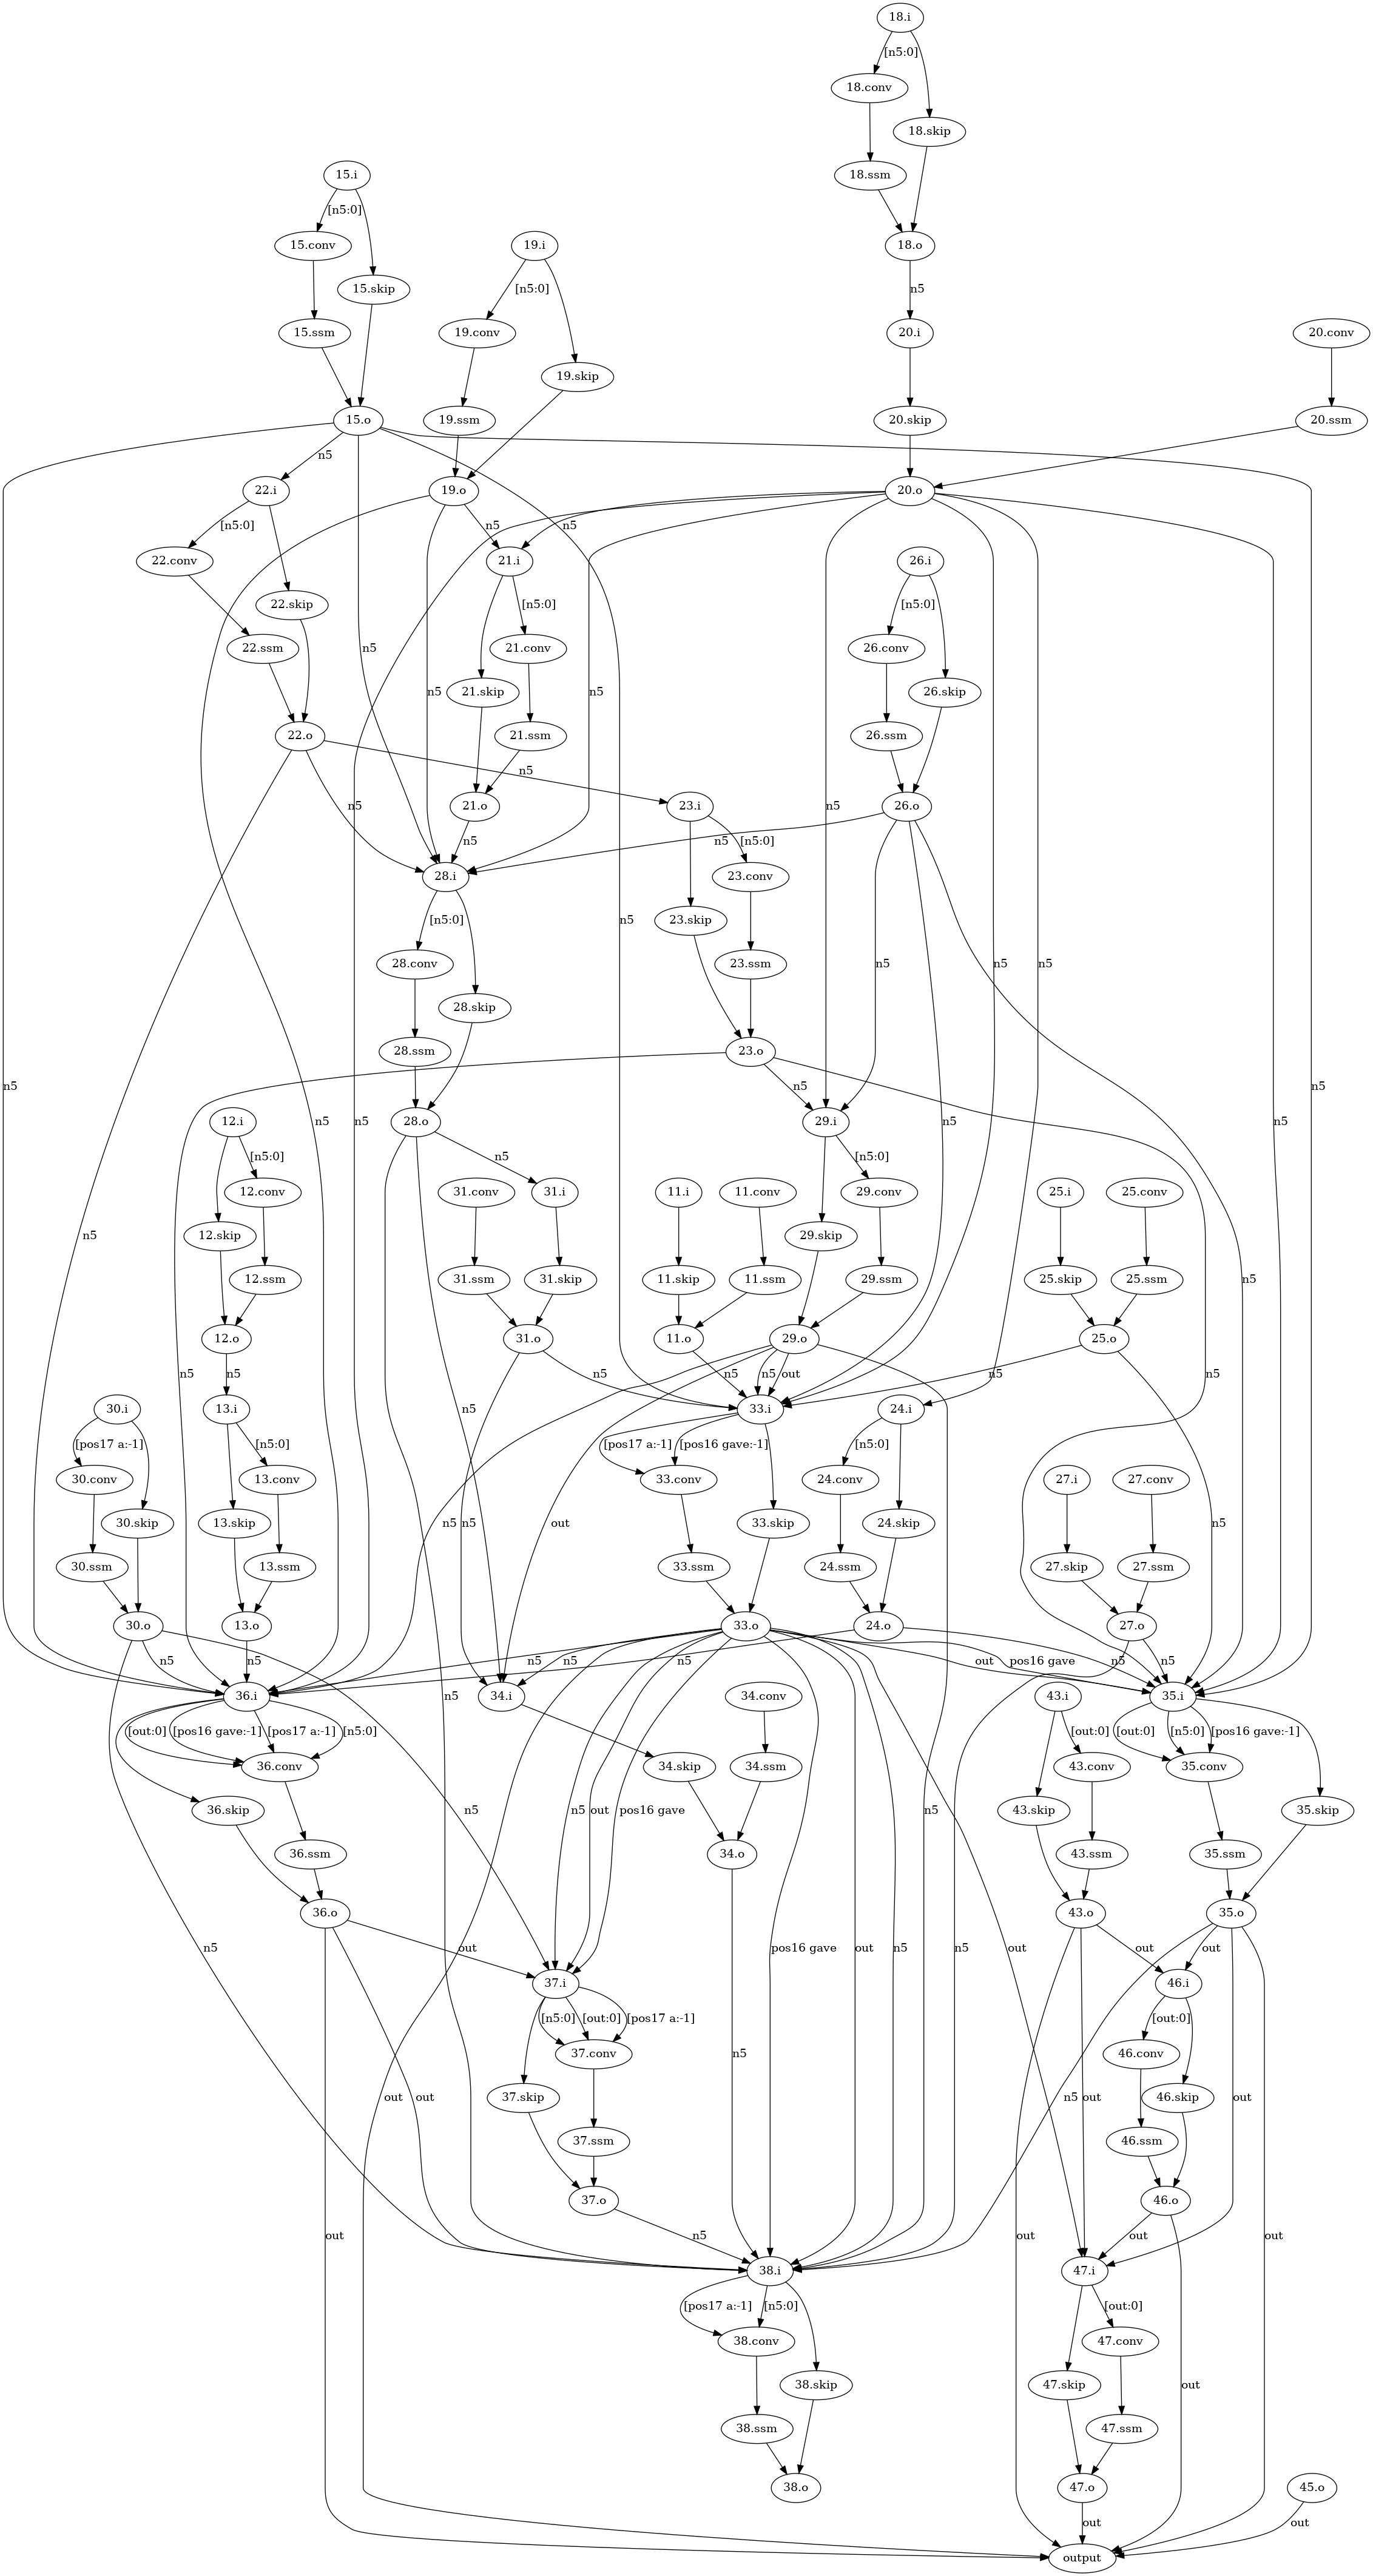

/home/dev/mamba_interp/pruned dot 0.85.png

In [43]:
import graphviz
def layer_to_i(layer):
    if layer == 'embed': return 0
    elif layer == 'output': return model.cfg.n_layers+1
    else: return int(layer)+1

forbidden = [0,1,40]
pruned_adj_mat = better_prune_edges(adj_mat)
for i in forbidden:
    pruned_adj_mat[:,i,:] = 0
    pruned_adj_mat[:,:,i] = 0
present_layers = set()
for i in range(model.cfg.n_layers):
    for j in range(model.cfg.n_layers):
        if not i+1 in forbidden and not j+1 in forbidden:
            if torch.any(pruned_adj_mat[:,i+1,j+1] != 0):
                present_layers.add(i)
                present_layers.add(j)
                #print(f"present edge {i}->{j}")
print(present_layers)
pruned_dot = graphviz.Digraph('graph')
for edge in edges_to_keep:
    is_between_layers, layer_input, layer_output = between_layers_info(edge)
    if is_between_layers:
        ini, outi = layer_to_i(layer_input), layer_to_i(layer_output)
        pos = int(edge.label)
        if pruned_adj_mat[pos, ini, outi] != 0:
            if not ini in forbidden and not outi in forbidden:
                pruned_dot.edge(edge.input_node, edge.output_node, label=position_map[int(edge.label)])
    else:
        layer = int(edge.input_node.split(".")[0])
        if layer in present_layers: # don't display stuff that are disconnected
            if '.ssm' in edge.output_node or '.skip' in edge.output_node or '.skip' in edge.input_node: # don't need all these since they are all forced on
                if edge.label == 0 or edge.label == "" or edge.label is None or edge.label == "0":
                    pruned_dot.edge(edge.input_node, edge.output_node)
            elif '.conv' in edge.output_node:
                label = edge.label
                # replace pos: with the more helpful labels
                for l in range(L):
                    start_from_back = L-l-1 # start from biggest number work backwards because like 10 contains a 1 so we need to do 10 first
                    prev_label = label
                    label = label.replace("[" + str(start_from_back) + ":", "[" + position_map[start_from_back] + ":")
                    if label != prev_label:
                        break
                pruned_dot.edge(edge.input_node, edge.output_node, label=label)
            else:
                pruned_dot.edge(edge.input_node, edge.output_node, label=edge.label)
output_name = f'pruned dot {ACC_THRESH}'
pruned_dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))

In [36]:
1+1

2